# Chess: DQN Learning Example

- This is skeleton code of a DQN learning. You can change any code line to build your own agent.
- TODO: Fill in the missing parts.
  - `hyper-parameters`
  - `create_q_model()`
  - `convert_state(board)`
  - `updated_q_values` (target Q value)

## [1] Prerequisite

### Constants

In [1]:
import gym
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

### TODO: Configuration paramaters for the whole setup
gamma = 0.99      # Discount factor for past rewards
epsilon = 1.0     # Epsilon greedy parameter
epsilon_min = 0.1    # Minimum epsilon greedy parameter
epsilon_max = 1.0     # Maximum epsilon greedy parameter
epsilon_interval = epsilon_max - epsilon_min # Rate at which to reduce chance of random action being taken
batch_size = 32    # Size of batch taken from replay buffer
max_steps_per_episode = 10000
max_episodes = 10000

num_actions = 4096
learning_rate = 0.001

# Number of frames to take random action and observe output
epsilon_random_frames = 50000
# Number of frames for exploration
epsilon_greedy_frames = 1000000
# Maximum replay length
# Note: The Deepmind paper suggests 1000000 however this causes memory issues
max_memory_length = 100000
# Train the model after 4 actions
update_after_actions = 4
# How often to update the target network
update_target_network = 10000

### Open Gym Environment for Chess

In [2]:
env = gym.make('ml_chess_env:ChessGreedyEnv')

### Build the Q Network

In [3]:
def create_q_model():
    # Network defined by the Deepmind paper
    inputs = layers.Input(shape=(64, ))

    # "Dense" is the basic form of a neural network layer
    # "Dense" stands for fully connected layer, which means each neuron in a layer
    # receives input from all neurons of the previous layer.
    layer1 = layers.Dense(128, activation="relu")(inputs)
    layer2 = layers.Dense(128, activation="relu")(layer1)
    action = layers.Dense(num_actions, activation="linear")(layer2)

    return keras.Model(inputs=inputs, outputs=action)

In [4]:
# The first model makes the predictions for Q-values which are used to
# make a action.
model = create_q_model()
# Build a target model for the prediction of future rewards.
# The weights of a target model get updated every 10000 steps thus when the
# loss between the Q-values is calculated the target Q-value is stable.
model_target = create_q_model()
# In the Deepmind paper they use RMSProp however then Adam optimizer
# improves training time
optimizer = keras.optimizers.Adam(learning_rate=learning_rate, clipnorm=1.0)
# Using huber loss for stability
loss_function = keras.losses.Huber()

### Initialize Lists for Replay Buffers

In [5]:
# Variables for counting over episodes
running_reward = 0
episode_count = 0
frame_count = 0

# Experience replay buffers
action_history = []
state_history = []
state_next_history = []
rewards_history = []
done_history = []
episode_reward_history = []

### Transform From Observation of Environment To State for Q-Network

In [13]:
def convert_state(board):
    """
    Convert environment state(=board) into state tensor(=model input)
    board : np.ndarray, shape=(64,)
    """
    ### TODO: write your code ###
    return np.array(board)

### Epsilon-Soft Greedy Policy & Greedy Policy

Note that <code>get_greedy_epsilon</code> is used for generating episodes in training steps for exploration and <code>get_greedy_action</code> is for get the best action when evaluating the resulting Q-network.

In [14]:
def get_greedy_epsilon(state, mask):
    global epsilon
    
    # Use epsilon-greedy for exploration
    if frame_count < epsilon_random_frames or epsilon > np.random.rand(1)[0]:
        # Take random action
        #action = np.random.choice(num_actions)
        action = np.random.choice([ i for i in range(num_actions) if mask[i] == 1 ])
    else:
        # Predict action Q-values
        # From environment state
        action_probs = model(np.expand_dims(state, 0), training=False)
        
        # select the action with maximum return with cells masked as 1
        valid_probs = [ (i, action_probs[0][i]) for i in range(num_actions) if mask[i] == 1 ]
        idx, val = max(valid_probs, key=lambda e: e[1])
        action = np.random.choice([ i for i, prob in valid_probs if prob >= val ])
    
    # decay epsilon
    epsilon -= epsilon_interval / epsilon_greedy_frames
    epsilon = max(epsilon, epsilon_min)
    
    return action

In [15]:
def get_greedy_action(state, mask):
    global epsilon
    
    # Predict action Q-values
    # From environment state
    action_probs = model(np.expand_dims(state, 0), training=False)
    
    valid_probs = [ (i, action_probs[0][i]) for i in range(num_actions) if mask[i] == 1 ]
    idx, val = max(valid_probs, key=lambda e: e[1])
    action = np.random.choice([ i for i, prob in valid_probs if prob >= val ])
    
    return action

### Sample A Batch from Replay Buffer

In [16]:
def sample_batch(batch_size):
    # Get indices of samples for replay buffers
    indices = np.random.choice(range(len(done_history)), size=batch_size)

    # Using list comprehension to sample from replay buffer
    state_sample = np.array([state_history[i] for i in indices])
    state_next_sample = np.array([state_next_history[i] for i in indices])
    rewards_sample = [rewards_history[i] for i in indices]
    action_sample = [action_history[i] for i in indices]
    done_sample = tf.convert_to_tensor(
        [float(done_history[i]) for i in indices]
    )
    
    return state_sample, state_next_sample, rewards_sample, action_sample, done_sample

## [2] DQN Tranining

In [17]:
for _ in range(max_episodes):  # Run until solved
    board, info = env.reset()
    state = convert_state(board)
    action_mask = info['action_mask']
    episode_reward = 0

    for timestep in range(1, max_steps_per_episode):
        # env.render(); Adding this line would show the attempts
        # of the agent in a pop up window.
        frame_count += 1

        # Use epsilon-greedy for exploration
        action = get_greedy_epsilon(state, action_mask)

        # Apply the sampled action in our environment
        board, reward, done, _, info = env.step(action)
        state_next = convert_state(board)
        action_mask = info['action_mask']

        # cummulate reward of the episode
        episode_reward += reward

        # Save actions and states in replay buffer
        action_history.append(action)
        state_history.append(state)
        state_next_history.append(state_next)
        done_history.append(done)
        rewards_history.append(reward)
        state = state_next

        # Update every fourth frame and once batch size is over 32
        if frame_count % update_after_actions == 0 and len(done_history) > batch_size:

            # Sample a batch from replay buffer
            state_sample, state_next_sample, rewards_sample, action_sample, done_sample = \
                sample_batch(batch_size)

            future_rewards = model_target.predict(state_next_sample, verbose=0)
            
            # Q value = reward + discount factor * maximum future reward
            updated_q_values = rewards_sample + gamma * tf.reduce_max(future_rewards, axis=1)  ### TODO: write your code ###

            # Create a mask so we only calculate loss on the updated Q-values
            masks = tf.one_hot(action_sample, num_actions)

            with tf.GradientTape() as tape:
                # Train the model on the states and updated Q-values
                q_values = model(state_sample)

                # Apply the masks to the Q-values to get the Q-value for action taken
                q_action = tf.reduce_sum(tf.multiply(q_values, masks), axis=1)
                
                # Calculate loss between new Q-value and old Q-value
                loss = loss_function(updated_q_values, q_action)

            # Backpropagation
            grads = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

        if frame_count % update_target_network == 0:
            # Periodically, update the the target network with new weights
            model_target.set_weights(model.get_weights())
            # Log details
            template = "model sync - running reward: {:.2f} at episode {}, frame count {}"
            print(template.format(running_reward, episode_count, frame_count))

        # Limit the state and reward history
        if len(rewards_history) > max_memory_length:
            del rewards_history[:1]
            del state_history[:1]
            del state_next_history[:1]
            del action_history[:1]
            del done_history[:1]

        if done:
            break

    # Update running reward to check condition for solving
    episode_reward_history.append(episode_reward)
    if len(episode_reward_history) > 100:
        del episode_reward_history[:1]
    running_reward = np.mean(episode_reward_history)

    episode_count += 1
    
    if episode_count % 10 == 0:
        print("# episode = {}: avg. reward = {}".format(episode_count, running_reward))

    if episode_count % 5000 == 0:
        model.save('model.{}'.format(episode_count))
        model_target.save('target_model.{}'.format(episode_count))

model.save('model.final')
model_target.save('target_model.final')

# episode = 10: avg. reward = 426.1
# episode = 20: avg. reward = 627.25
# episode = 30: avg. reward = 595.1333333333333
# episode = 40: avg. reward = 528.325
# episode = 50: avg. reward = 508.78
# episode = 60: avg. reward = 512.5833333333334
# episode = 70: avg. reward = 486.0285714285714
# episode = 80: avg. reward = 516.65
model sync - running reward: 541.15 at episode 86, frame count 10000
# episode = 90: avg. reward = 529.5
# episode = 100: avg. reward = 479.4
# episode = 110: avg. reward = 459.48
# episode = 120: avg. reward = 409.71
# episode = 130: avg. reward = 439.71
# episode = 140: avg. reward = 469.81
# episode = 150: avg. reward = 489.42
# episode = 160: avg. reward = 509.41
# episode = 170: avg. reward = 508.96
model sync - running reward: 488.85 at episode 177, frame count 20000
# episode = 180: avg. reward = 488.76
# episode = 190: avg. reward = 459.01
# episode = 200: avg. reward = 509.5
# episode = 210: avg. reward = 519.88
# episode = 220: avg. reward = 549.32
# ep

KeyboardInterrupt: 

## [3] Evaluation

In [18]:
import time
from IPython.display import clear_output, display

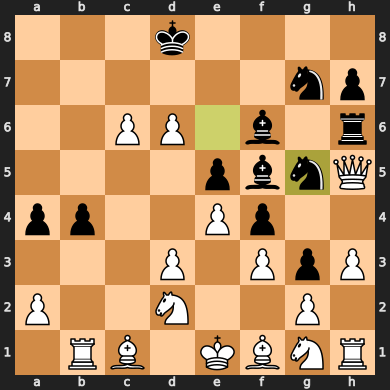

In [19]:
board, info = env.reset()
done = False

for timestep in range(1, 80):
    state = convert_state(board)
    action_mask = info['action_mask']
    
    move = get_greedy_action(state, action_mask)
    board, reward, done, _, info = env.step(move)
    
    clear_output()
    display(env.render())
    time.sleep(1)
    
    if done:
        break

In [20]:
info

{'action_mask': array([False, False, False, ..., False, False, False]),
 'material_value': 15,
 'result': '*',
 'termination': ''}